In [1]:
# STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")


In [3]:
# STEP 2: Load the Dataset
df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')
print("Initial Shape:", df.shape)
df.head()


Initial Shape: (282, 16)


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [6]:
# Ensure the columns are strings first (optional but safe)
df['creation_time'] = df['creation_time'].astype(str)
df['end_time'] = df['end_time'].astype(str)

# Now convert to datetime
df['creation_time'] = pd.to_datetime(df['creation_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')

# Drop rows where datetime conversion failed
df.dropna(subset=['creation_time', 'end_time'], inplace=True)


In [7]:
# Feature Engineering - Safe calculation
df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

# Handle 0 or NaNs in duration
df['duration_seconds'] = df['duration_seconds'].replace(0, np.nan)
df['duration_seconds'].fillna(1, inplace=True)

# Ensure numeric types for byte columns
df['bytes_in'] = pd.to_numeric(df['bytes_in'], errors='coerce').fillna(0)
df['bytes_out'] = pd.to_numeric(df['bytes_out'], errors='coerce').fillna(0)

# Compute average packet size
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['duration_seconds']


In [8]:
print(df[['creation_time', 'end_time', 'duration_seconds', 'avg_packet_size']].head())


              creation_time                  end_time  duration_seconds  \
0 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00             600.0   
1 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00             600.0   
2 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00             600.0   
3 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00             600.0   
4 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00             600.0   

   avg_packet_size  
0        30.986667  
1        81.830000  
2        69.956667  
3        74.706667  
4        34.030000  


In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['bytes_in', 'bytes_out', 'duration_seconds']])

# One-hot encode categorical feature
encoder = OneHotEncoder(sparse_output=False)  # or sparse=False depending on sklearn version
encoded = encoder.fit_transform(df[['src_ip_country_code']])


In [10]:
# Create DataFrames for scaled and encoded features
df_scaled = pd.DataFrame(scaled_features, columns=['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration'], index=df.index)
df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['src_ip_country_code']), index=df.index)

# Combine all into a new transformed DataFrame
df_transformed = pd.concat([df.reset_index(drop=True), df_scaled, df_encoded], axis=1)

# View first few rows
df_transformed.head()


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,...,scaled_bytes_in,scaled_bytes_out,scaled_duration,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,...,-0.288219,-0.281223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,...,-0.282108,-0.260804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,...,-0.282689,-0.279344,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,...,-0.282197,-0.276161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,-0.287996,-0.277678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
from sklearn.ensemble import IsolationForest

# Use numeric features only
anomaly_features = df[['bytes_in', 'bytes_out', 'duration_seconds', 'avg_packet_size']]

# Isolation Forest
iso_model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso_model.fit_predict(anomaly_features)
df['anomaly'] = df['anomaly'].map({1: 'Normal', -1: 'Suspicious'})

# Count of anomalies
print(df['anomaly'].value_counts())


anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64


In [34]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score
# Label: 'is_suspicious' = 1 if 'waf_rule' detection type 
df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)
# Features and label 
X = df[['bytes_in', 'bytes_out', 'duration_seconds']] 
y = df['is_suspicious']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Model training 
rf = RandomForestClassifier(n_estimators=100, random_state=42) 
rf.fit(X_train, y_train)
# Prediction 
y_pred = rf.predict(X_test)
# Evaluation 
print("Accuracy:", accuracy_score(y_test, y_pred)) 
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



In [21]:
print(df.columns)


Index(['bytes_in', 'bytes_out', 'end_time', 'src_ip', 'src_ip_country_code',
       'protocol', 'response.code', 'dst_port', 'dst_ip', 'rule_names',
       'observation_name', 'source.meta', 'source.name', 'time',
       'detection_types', 'duration_seconds', 'avg_packet_size',
       'is_suspicious'],
      dtype='object')


In [22]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df.set_index('time', inplace=True)


In [23]:
df.columns = df.columns.str.strip()
print(df.columns)


Index(['bytes_in', 'bytes_out', 'end_time', 'src_ip', 'src_ip_country_code',
       'protocol', 'response.code', 'dst_port', 'dst_ip', 'rule_names',
       'observation_name', 'source.meta', 'source.name', 'detection_types',
       'duration_seconds', 'avg_packet_size', 'is_suspicious'],
      dtype='object')


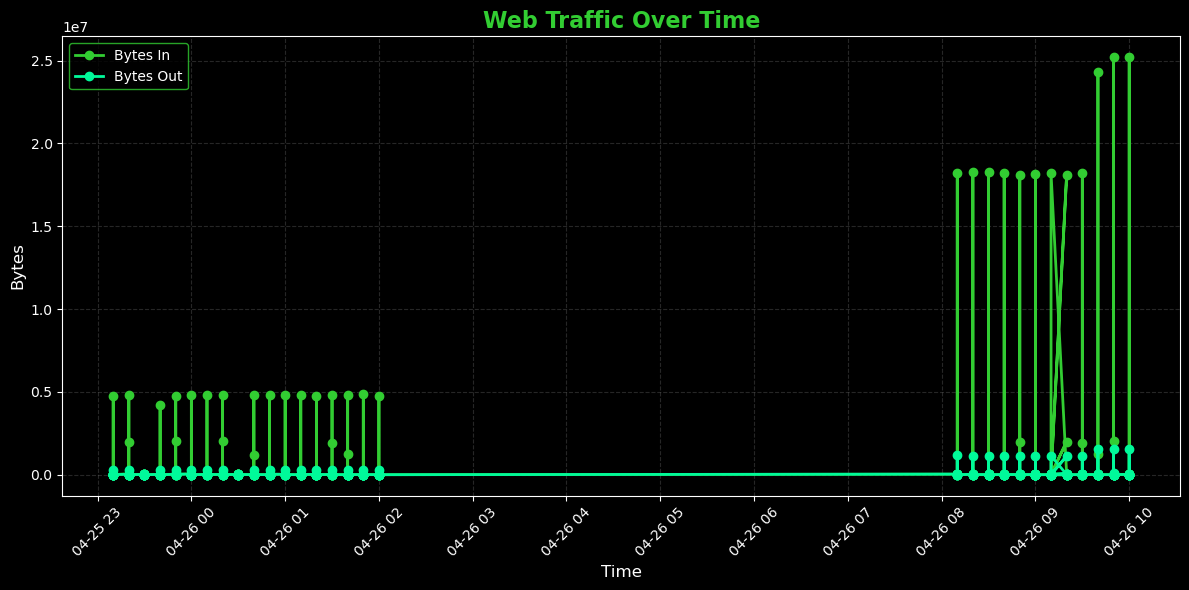

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Clean up any whitespace in column names
df.columns = df.columns.str.strip()

# Convert 'end_time' to datetime and set as index
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')
df.set_index('end_time', inplace=True)

# Dark theme
plt.style.use("dark_background")

# Plot Bytes In and Bytes Out
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['bytes_in'], 
         label='Bytes In', 
         marker='o', 
         color='limegreen', 
         linewidth=2)

plt.plot(df.index, df['bytes_out'], 
         label='Bytes Out', 
         marker='o', 
         color='mediumspringgreen', 
         linewidth=2)

plt.title('Web Traffic Over Time', fontsize=16, fontweight='bold', color='limegreen')
plt.xlabel('Time', fontsize=12, color='white')
plt.ylabel('Bytes', fontsize=12, color='white')
plt.legend(facecolor="black", edgecolor="limegreen", labelcolor="white")
plt.grid(color="gray", linestyle="--", alpha=0.3)
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")
plt.tight_layout()
plt.show()


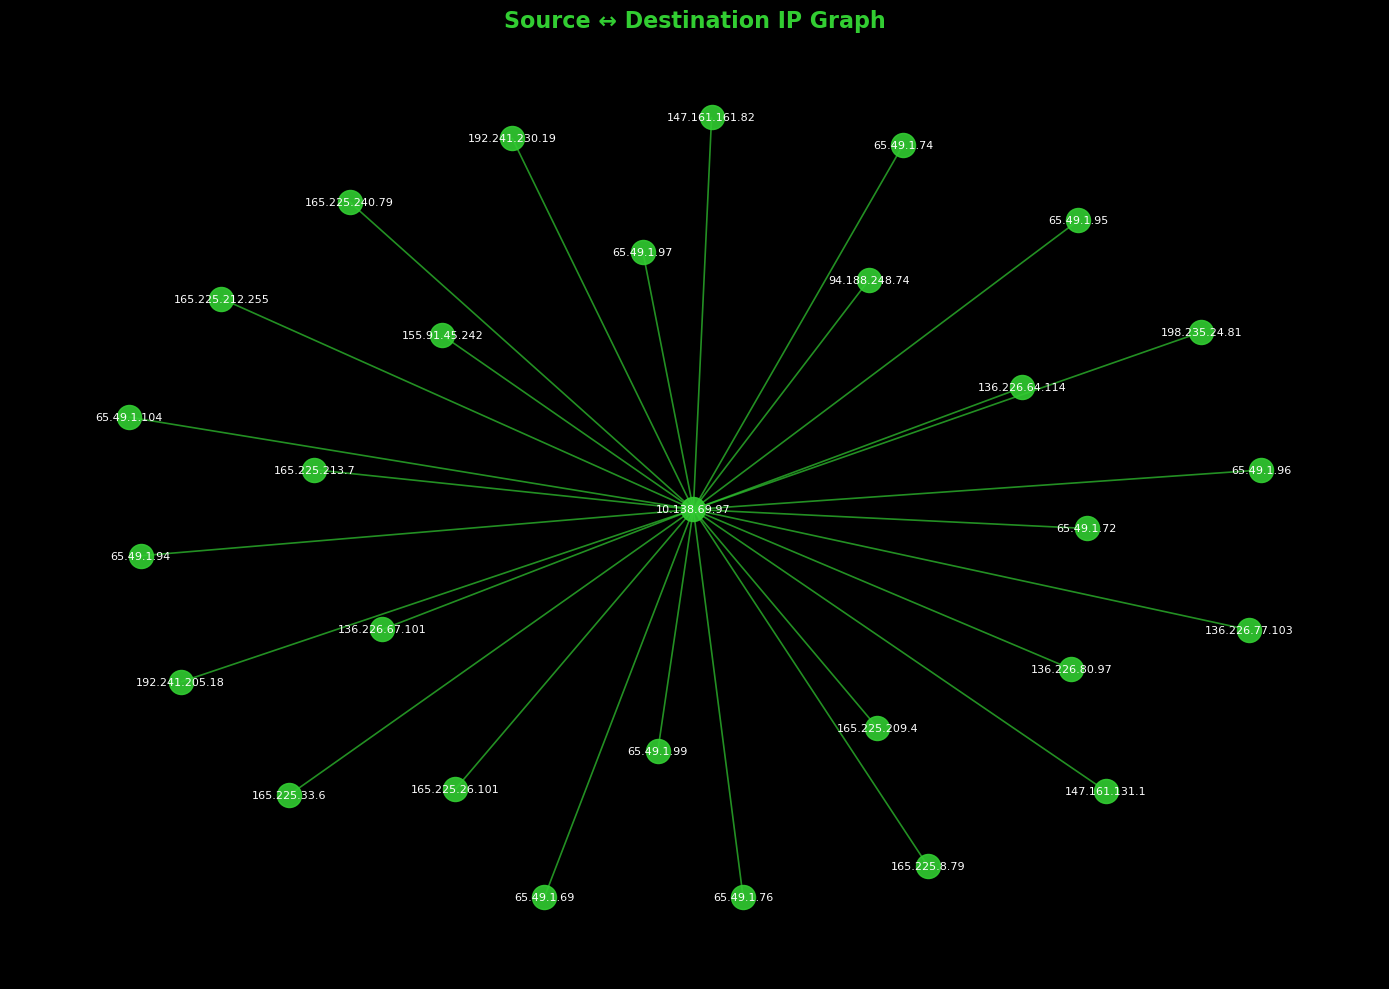

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

# Create graph
G = nx.Graph()
edges = list(zip(df["src_ip"], df["dst_ip"]))
G.add_edges_from(edges)

# Dark background
plt.style.use("dark_background")

# Layout
pos = nx.spring_layout(G, k=0.3, seed=42)

# Plot
plt.figure(figsize=(14, 10))

# Nodes (green)
nx.draw_networkx_nodes(G, pos,
                       node_size=300,
                       node_color="limegreen",  # bright green
                       alpha=0.9)

# Edges (green)
nx.draw_networkx_edges(G, pos,
                       edge_color="limegreen",
                       width=1.2,
                       alpha=0.7)

# Labels (light grey for readability on dark bg)
nx.draw_networkx_labels(G, pos,
                        font_size=8,
                        font_color="white")

plt.title("Source ↔ Destination IP Graph", 
          fontsize=16, fontweight="bold", color="limegreen")
plt.axis("off")
plt.tight_layout()
plt.show()


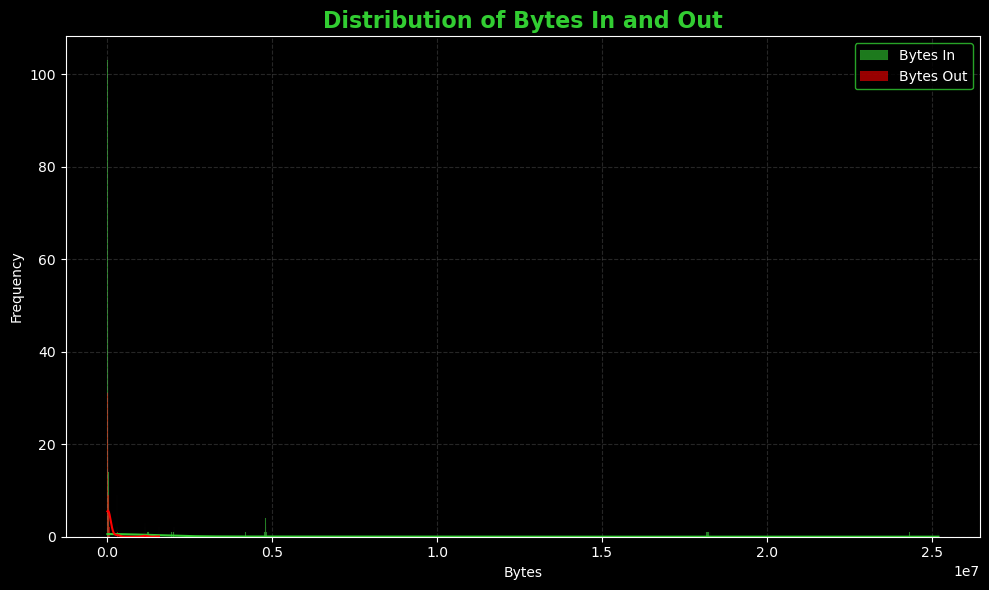

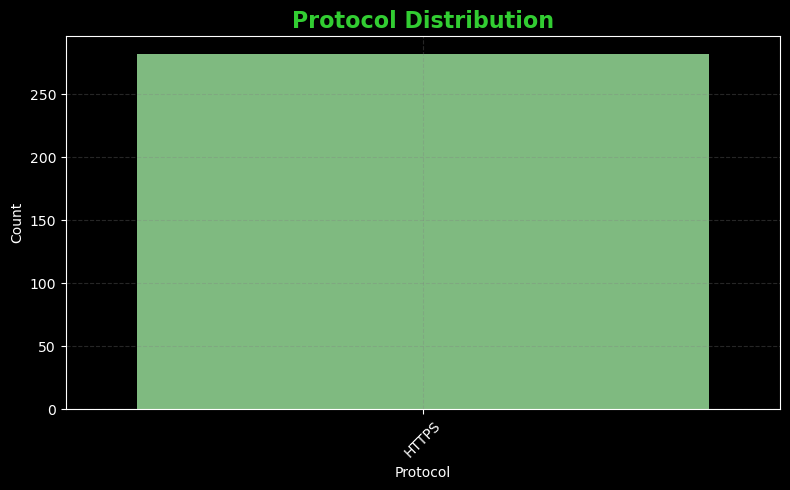

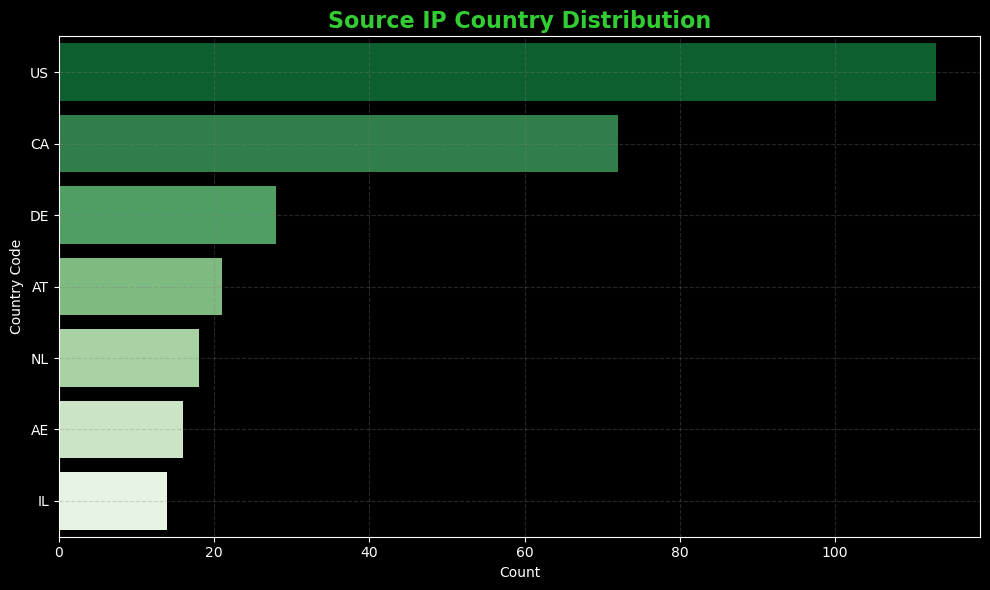

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use dark theme
plt.style.use("dark_background")

# 1. Distribution of Bytes
plt.figure(figsize=(10, 6))
sns.histplot(df['bytes_in'], color='limegreen', label='Bytes In', kde=True, alpha=0.6)
sns.histplot(df['bytes_out'], color='red', label='Bytes Out', kde=True, alpha=0.6)
plt.title('Distribution of Bytes In and Out', fontsize=16, fontweight="bold", color="limegreen")
plt.xlabel("Bytes", color="white")
plt.ylabel("Frequency", color="white")
plt.legend(facecolor="black", edgecolor="limegreen", labelcolor="white")
plt.xticks(color="white")
plt.yticks(color="white")
plt.grid(color="gray", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Protocol Count
plt.figure(figsize=(8, 5))
sns.countplot(x='protocol', data=df, palette="Greens_r")
plt.title('Protocol Distribution', fontsize=16, fontweight="bold", color="limegreen")
plt.xlabel("Protocol", color="white")
plt.ylabel("Count", color="white")
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")
plt.grid(color="gray", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Country-wise Interaction
plt.figure(figsize=(10, 6))
sns.countplot(y='src_ip_country_code',
              data=df,
              order=df['src_ip_country_code'].value_counts().index,
              palette="Greens_r")
plt.title('Source IP Country Distribution', fontsize=16, fontweight="bold", color="limegreen")
plt.xlabel("Count", color="white")
plt.ylabel("Country Code", color="white")
plt.xticks(color="white")
plt.yticks(color="white")
plt.grid(color="gray", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
